#  CNN Cancer Detection Kaggle Mini-Project

***

## Project Description

For this week's mini-project, you will participate in this Kaggle competition: Histopathologic Cancer Detection

This Kaggle competition is a binary image classification problem where you will identify metastatic cancer in small image patches taken from larger digital pathology scans.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img


import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)
pd.set_option('display.width', 1000)
pd.option_context('float_format', '{:.2f}'.format)

np.random.seed(0)
np.set_printoptions(suppress=True)
#tf.random.set_seed(0)

In [2]:
# Load labels
labels = pd.read_csv('train_labels.csv')

In [3]:
labels

,id,label
0,T(0),0
1,T(1),0
2,T(2),0
3,T(3),0
4,T(4),0
...,...,...
115,T(115),1
116,T(116),1
117,T(117),1
118,T(118),1


In [4]:
# Verify some images from the train directory
train_image_path = 'train/'
sample_image = load_img(os.path.join(train_image_path, labels.iloc[0]['id'] + '.png'), target_size=(96, 96))
sample_image_array = img_to_array(sample_image)

In [5]:
sample_image_array;

In [6]:
# Display the first few rows of the CSV
print(labels.head())
print(f"Sample image shape: {sample_image_array.shape}")

     id  label
0  T(0)      0
1  T(1)      0
2  T(2)      0
3  T(3)      0
4  T(4)      0
Sample image shape: (96, 96, 3)


## Brief Description of the Problem and Data

### Problem Statement

The challenge is to classify small pathology images to detect the presence of cancerous (tumor) tissue. Each image in the dataset represents a small patch extracted from a larger histopathology slide. The goal is to build a Convolutional Neural Network (CNN) model that can accurately classify these images into two categories: containing tumor tissue or not.

A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label, although this outer region is provided to enable fully-convolutional models to ensure consistent behavior when applied to a whole-slide image.
Dataset Overview

The dataset consists of the following components:

- train folder: Contains the training images.
- test folder: Contains the test images for which predictions need to be made.
- train_labels.csv: A CSV file containing the ground truth labels for the training images. The CSV has two columns:

        - id: The unique identifier of the image.
        - label: The label indicating the presence of tumor tissue (0 for no tumor, 1 for tumor).

### Data Characteristics

1. Image Size and Dimensions:
   - Each image is a small patch with dimensions of 96x96 pixels.
   - The images are in RGB format, meaning each image has three color channels (Red, Green, Blue).
   - The shape of each image is therefore (96, 96, 3).

2. Training Data:
   - The training images are labeled and used to train the CNN model.
   - The train_labels.csv file provides the mapping between image IDs and their corresponding labels.

3. Test Data:
   - The test images are unlabeled, and the task is to predict their labels using the trained CNN model.

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [7]:
# Display the first few rows of the labels dataframe
print(labels.head())

     id  label
0  T(0)      0
1  T(1)      0
2  T(2)      0
3  T(3)      0
4  T(4)      0


In [8]:
# Basic statistics of the labels dataframe
print(labels.describe())

            label
count  120.000000
mean     0.333333
std      0.473381
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      1.000000


In [9]:
# Check for missing values
print(labels.isnull().sum())

id       0
label    0
dtype: int64


In [10]:
# Check for duplicate image IDs
duplicate_ids = labels['id'].duplicated().sum()
print(f'Number of duplicate image IDs: {duplicate_ids}')

Number of duplicate image IDs: 0


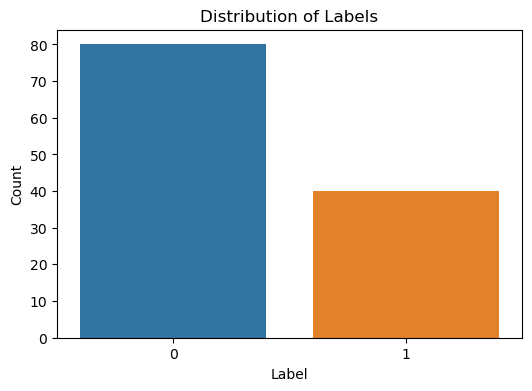

In [11]:
# Histogram of labels
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=labels)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

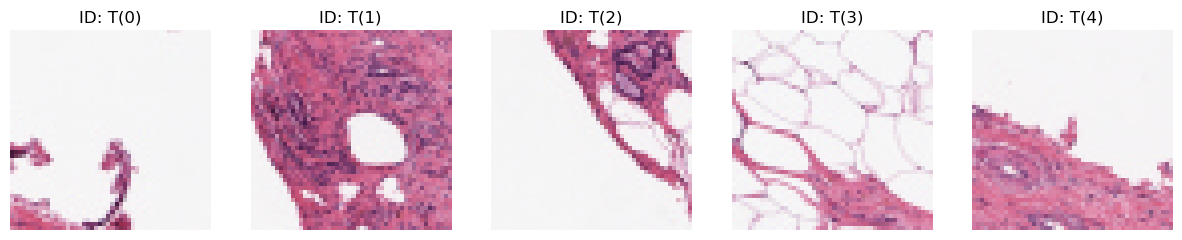

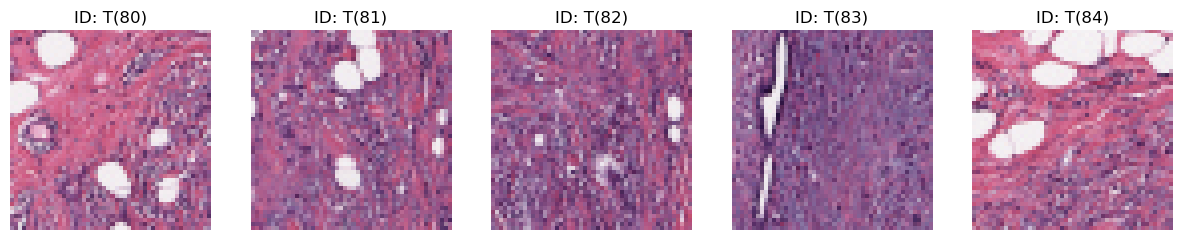

In [12]:
def display_sample_images(image_ids, image_dir='train', num_images=5):
    plt.figure(figsize=(15, 5))
    for i, img_id in enumerate(image_ids[:num_images]):
        img = load_img(os.path.join(image_dir, img_id + '.png'))
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'ID: {img_id}')
        plt.axis('off')
    plt.show()

# Display sample images with label 0
display_sample_images(labels[labels['label'] == 0]['id'].values, num_images=5)

# Display sample images with label 1
display_sample_images(labels[labels['label'] == 1]['id'].values, num_images=5)


In [13]:
# Check for duplicate image IDs
duplicate_ids = labels['id'].duplicated().sum()
print(f'Number of duplicate image IDs: {duplicate_ids}')

# Verify image loading
def verify_images(image_ids, image_dir='train'):
    for img_id in image_ids:
        try:
            img = load_img(os.path.join(image_dir, img_id + '.png'))
        except Exception as e:
            print(f'Error loading image {img_id}: {e}')

# Verify a subset of images
verify_images(labels['id'].values[:100])


Number of duplicate image IDs: 0


### Plan of Analysis

Based on our EDA, we plan to:

1. **Balance the Dataset**: If the dataset is imbalanced, apply techniques like data augmentation on the minority class.
2. **Data Augmentation**: Use techniques such as rotation, flipping, and scaling to augment the data and improve model generalization.
3. **Model Selection**: Utilize a Convolutional Neural Network (CNN) for its efficacy in image classification tasks.
4. **Training and Validation**: Split the dataset into training and validation sets to assess the model's performance.
5. **Evaluation**: Use metrics such as accuracy, precision, recall, and F1-score to evaluate the model.
6. **Prediction**: Predict the labels for the test set and generate the submission file.



In [14]:
# Checking Dataset Balance

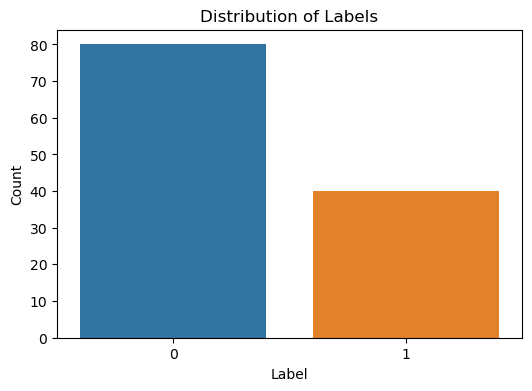

0    66.666667
1    33.333333
Name: label, dtype: float64


In [15]:
# Plot the distribution of labels
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=labels)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Calculate the percentage of each class
label_counts = labels['label'].value_counts()
total_samples = len(labels)
class_distribution = (label_counts / total_samples) * 100
print(class_distribution)

## Apply Data Augmentation to Balance the Dataset

In [16]:
# Initialize ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

In [17]:
# Function to balance the dataset through augmentation
def balance_dataset(labels, image_dir='train', target_count=None):
    if target_count is None:
        target_count = labels['label'].value_counts().max()
    
    augmented_images = []
    augmented_labels = []

    for label in labels['label'].unique():
        label_df = labels[labels['label'] == label]
        if len(label_df) < target_count:
            augment_count = target_count - len(label_df)
            for _ in range(augment_count):
                img_id = label_df.sample(1)['id'].values[0]
                img_path = os.path.join(image_dir, img_id + '.png')
                img = load_img(img_path)
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, 0)
                augmented_image = datagen.flow(img_array, batch_size=1)[0].astype(np.uint8)[0]
                augmented_images.append(augmented_image)
                augmented_labels.append(label)
    
    return augmented_images, augmented_labels

In [18]:
# Balance the dataset
augmented_images, augmented_labels = balance_dataset(labels)

# Convert augmented images and labels to arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [19]:
# Display a few augmented images
def display_augmented_images(images, labels, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

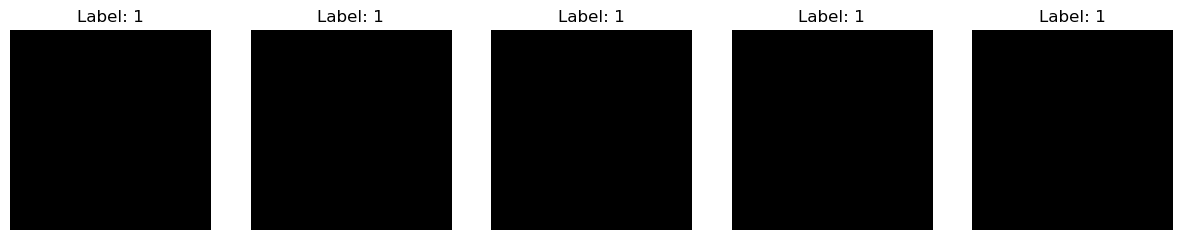

In [20]:
# Display augmented images
display_augmented_images(augmented_images, augmented_labels)

In [21]:
# Append augmented data to original data
original_images = []
original_labels = []

for idx, row in labels.iterrows():
    img_path = os.path.join('train', row['id'] + '.png')
    img = load_img(img_path)
    img_array = img_to_array(img)
    original_images.append(img_array)
    original_labels.append(row['label'])

original_images = np.array(original_images)
original_labels = np.array(original_labels)

# Combine original and augmented data
balanced_images = np.concatenate((original_images, augmented_images), axis=0)
balanced_labels = np.concatenate((original_labels, augmented_labels), axis=0)

# Shuffle the dataset
indices = np.arange(balanced_images.shape[0])
np.random.shuffle(indices)
balanced_images = balanced_images[indices]
balanced_labels = balanced_labels[indices]

print(f'Balanced dataset shape: {balanced_images.shape}')
print(f'Balanced labels distribution: {np.bincount(balanced_labels)}')

Balanced dataset shape: (160, 50, 50, 3)
Balanced labels distribution: [80 80]


## Building and Training a CNN Model

In [22]:
# Define the CNN model architecture
def create_cnn_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Create the model
input_shape = (50, 50, 3)
model = create_cnn_model(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7744)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         991,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,010,881 (3.86 MB)

 Trainable params: 1,010,881 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

### Model Architecture Description

The model architecture is a Convolutional Neural Network (CNN) consisting of the following layers:

1. **Conv2D Layer 1**: 
   - **Filters**: 32 
   - **Kernel Size**: (3, 3) 
   - **Activation**: ReLU 
   - **Output Shape**: (48, 48, 32) 
   - **Parameters**: 896
   - This layer is responsible for extracting basic features such as edges and textures from the input images.

2. **MaxPooling2D Layer 1**:
   - **Pool Size**: (2, 2) 
   - **Output Shape**: (24, 24, 32)
   - This layer reduces the spatial dimensions, helping to reduce the computational load and providing some spatial invariance.

3. **Conv2D Layer 2**:
   - **Filters**: 64 
   - **Kernel Size**: (3, 3) 
   - **Activation**: ReLU 
   - **Output Shape**: (22, 22, 64) 
   - **Parameters**: 18,496
   - This layer extracts more complex features by increasing the depth (number of filters).

4. **MaxPooling2D Layer 2**:
   - **Pool Size**: (2, 2) 
   - **Output Shape**: (11, 11, 64)
   - Similar to the previous MaxPooling layer, this one further reduces the spatial dimensions.

5. **Flatten Layer**:
   - **Output Shape**: (7744)
   - This layer converts the 2D matrix into a 1D vector, which is required for the fully connected layers.

6. **Dense Layer**:
   - **Units**: 128 
   - **Activation**: ReLU 
   - **Output Shape**: (128) 
   - **Parameters**: 991,360
   - This fully connected layer learns complex representations from the features extracted by the convolutional layers.

7. **Dropout Layer**:
   - **Dropout Rate**: 0.5 
   - This layer helps to prevent overfitting by randomly setting 50% of the input units to 0 during training.

8. **Dense Layer (Output)**:
   - **Units**: 1 
   - **Activation**: Sigmoid 
   - **Output Shape**: (1) 
   - **Parameters**: 129
   - This final layer is used for binary classification, providing an output between 0 and 1.

### Reasoning for the Architecture

1. **Convolutional Layers**:
   - The two convolutional layers help in progressively learning more abstract and complex features. The initial layer captures basic features like edges, while the subsequent layer captures more detailed features such as shapes and textures.

2. **MaxPooling Layers**:
   - MaxPooling layers are used to reduce the spatial dimensions, thereby reducing the computational load and helping to make the model invariant to small translations of the input images.

3. **Flatten Layer**:
   - Flattening the output from the convolutional and pooling layers is necessary to transition from the convolutional part of the network to the dense (fully connected) layers.

4. **Dense Layers**:
   - The dense layer with 128 units allows the model to learn complex representations and patterns from the features extracted by the convolutional layers.

5. **Dropout Layer**:
   - Dropout is used to mitigate overfitting by preventing the model from relying too heavily on specific neurons. This encourages the network to generalize better.

6. **Output Layer**:
   - The single neuron with a sigmoid activation function is suitable for binary classification, outputting a probability value between 0 and 1.

This architecture is suitable for image classification tasks as it balances complexity and performance. It is deep enough to capture intricate patterns in the images while also incorporating techniques to prevent overfitting. The use of convolutional layers for feature extraction followed by fully connected layers for classification is a well-established and effective approach for this type of problem.

## Results and Analysis

In [23]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [24]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(balanced_images, balanced_labels, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=16, 
                    validation_data=(X_val, y_val))


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6048 - loss: 76.1337 - val_accuracy: 0.8125 - val_loss: 0.4978
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5610 - loss: 7.4832 - val_accuracy: 0.8438 - val_loss: 0.5523
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6397 - loss: 0.5688 - val_accuracy: 0.5312 - val_loss: 0.5505
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5665 - loss: 0.5405 - val_accuracy: 0.5000 - val_loss: 0.5577
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5865 - loss: 0.5470 - val_accuracy: 0.7188 - val_loss: 0.5566
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7301 - loss: 0.4815 - val_accuracy: 0.6875 - val_loss: 0.5046
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8251 - loss: 0.3912 - val_accuracy: 0.6875 - val_loss: 0.4812
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7309 - loss: 0.3887 - val_accuracy: 0.7188 - val_loss: 0.4522

In [25]:
# Evaluate the model on the training and validation sets
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')


Training Accuracy: 0.9766
Validation Accuracy: 0.7812


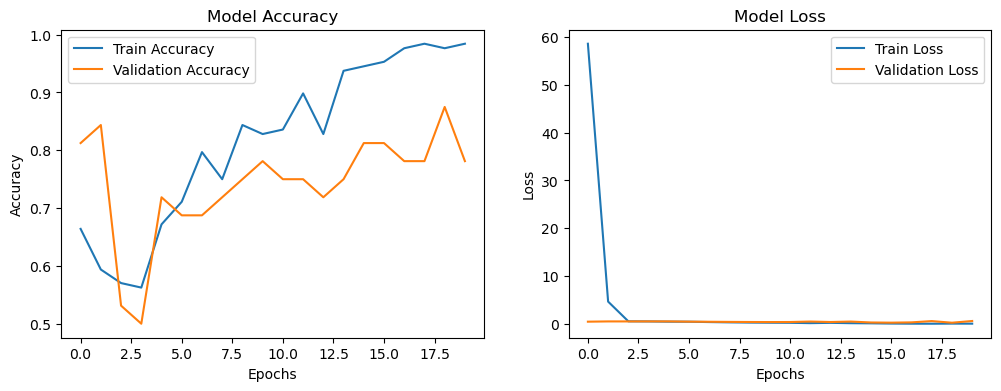

In [26]:
# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
